In [1]:
import numpy as np
from scipy.optimize import minimize, brute
import scipy
from scipy.linalg import solve_continuous_lyapunov
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from scipy.io import loadmat
import os
np.set_printoptions(precision=3)
from itertools import groupby

In [2]:
def convert_params(params): 
    c = params[3] 
    J = np.array([[-params[0], params[2]], [-params[0]*c, -params[1]]])
    B = np.diagflat(params[4:])**2 
    B[1, 1] += c*c*B[0, 0] 
    B[1, 0] = c*B[0, 0]
    B[0, 1] = B[1, 0] 
    return J, B 

In [3]:
class simple_model(): 
    
    def __init__(self, params):
        self.J, B = convert_params(params)
        self.rv =  multivariate_normal([0, 0], B)
        
    def evolve(self, T, dt, n_frames, n_repeats):
        results = [] 
        for n in range(n_repeats): 
            y = np.zeros((2))
            res = np.zeros((n_frames, 2))
            for i in range(n_frames):
                for j in range(int(T/n_frames/dt)):
                    self._update(y, dt)
                res[i] = np.copy(y)
            results.append(res.T) 
        return results 


    def _update(self, y, dt):
        det = self.J @ y * dt 
        sto = np.sqrt(dt)*self.rv.rvs()
        y += det + sto 
        
        
class inference():
    
    def __init__(self):
        pass 
    
    def inf(self, guess, trajs, dt, bounds=None, brute_force=False, method='trust-constr'):   
        cost = lambda x: self._minuslogP(x, trajs, dt)
        if bounds is None: 
            bounds = [[1e-6, 10]]*6 
        if brute_force: 
            res = brute(cost, bounds, Ns=100)
            MAP, cost = res[0], res[1]
        else: 
            res = minimize(cost, guess, bounds=bounds, method=method)
            MAP, cost = res.x, res.fun 
        return MAP, cost
           
    def _minuslogP(self, params, trajs, dt):
        '''
        traj: 2 x T 
        '''
        J, B = convert_params(params)
        self._set_up(J, dt)
        invcov = np.linalg.inv(self._cov(J, B)) 
        sign, norm = np.linalg.slogdet(invcov)
        
        minuslogp = 0 
        for traj in trajs: 
            T = traj.shape[-1]-1
            xm = self.evo @ traj[:, :-1]
            diff = (traj[:, 1:] - xm)
            minuslogp += np.einsum('ji,jk,ki', diff, invcov, diff).real/2 
            minuslogp -= T*norm/2
        return minuslogp

    def _set_up(self, J, dt):
        self.evo =  scipy.linalg.expm(J*dt)
        
    def _cov(self, J, B):
        c = solve_continuous_lyapunov(J, -B)  
        return - self.evo @ c @ self.evo.T + c 
    
class exact_inference(inference): 
    
    def _minuslogP(self, J, B, trajs, dt):
        self._set_up(J, dt)
        invcov = np.linalg.inv(self._cov(J, B)) 
        sign, norm = np.linalg.slogdet(invcov)
        
        minuslogp = 0 
        for traj in trajs: 
            T = traj.shape[-1]-1
            xm = self.evo @ traj[:, :-1]
            diff = (traj[:, 1:] - xm)
            minuslogp += np.einsum('ji,jk,ki', diff, invcov, diff).real/2 
            minuslogp -= T*norm/2
        return minuslogp
    
    def inf(self, trajs, dt):

        T1 = np.zeros((2, 2))
        T2 = np.zeros((2, 2))
        T3 = np.zeros((2, 2))
        for traj in trajs: 
            t1, t2, t3 = self._compute_suff_stats(traj) 
            T1 += t1 
            T2 += t2 
            T3 += t3 
        T3_inv = np.linalg.inv(T3)
        Q = T2 @ T3_inv
        Cov = (T1 - T2 @ T3_inv @ T2.T)/np.sum([traj.shape[-1] -1 for traj in trajs])

        J = scipy.linalg.logm(Q)/dt 
        c = scipy.linalg.solve_discrete_lyapunov(Q, Cov)
        B = - J @ c - c @ J.T 
        return J, B


    def _compute_suff_stats(self, traj):
        x_later = traj[:, 1:]
        x_earlier = traj[:, :-1]
        T1 = self._outer(x_later, x_later)
        T2 = self._outer(x_later, x_earlier)
        T3 = self._outer(x_earlier, x_earlier)
        return T1, T2, T3 

    def _outer(self, a, b): 
            return np.einsum('ij,kj->ik', a, b)

### First, we make some simulations with known parameters and infer them with both inference methods

In [7]:
# params in order of [epsilon, gamma-mu*c, mu, c]
T = 5e2
dt = 5e-3
n_frames = int(1*T) 
n_repeats = 5

params = [0.01, 0.1, 0.5, 1, 0.1, 0.33]
J, B = convert_params(params)
print(J)
print(B)
print(np.linalg.eigvals(J))

m = simple_model(params)
results = m.evolve(T, dt, n_frames, n_repeats)

[[-0.01  0.5 ]
 [-0.01 -0.1 ]]
[[0.01  0.01 ]
 [0.01  0.119]]
[-0.055+0.055j -0.055-0.055j]


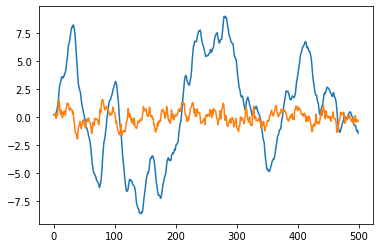

In [8]:
plt.plot(results[0][0])
plt.plot(results[0][1])
plt.show()

In [14]:
## Exact inference without constraints

inf = exact_inference() 
inf.inf(results, 1)

(array([[-0.009,  0.498],
        [-0.008, -0.14 ]]),
 array([[-0.01 , -0.011],
        [-0.011, -0.121]]))

In [52]:
## Numerical inference with constraints 

inf = inference()
guess = [1, 1, 1, 1, 1, 1]
MAP, cost = inf.inf(guess, sims, 1, brute_force=False)
print(MAP, cost)

[6.774e-04 6.223e-02 1.121e-02 1.200e+00 4.521e-03 7.095e-02] -176831.04242240064


In [5]:
# path = 'Data/N15_ThetaPola_DATA/' 
path = 'Data/N11_ThetaPola_DATA/'
files = [path + f for f in os.listdir(path) if f.endswith('mat')]
files.sort() # sort files so the polarization and theta are right next to each other in the list 

for element1, element2 in zip(files[::2], files[1::2]):
    print(f"{element1:} {element2:}")

theta_trajs = [] 
pol_trajs = []

for f in files: 
    if f.endswith('POLARIZATION.mat'):
        pol_trajs.append(loadmat(f)['POLA'])
    else: 
        theta_trajs.append(loadmat(f)['THETAd'])

Data/N11_ThetaPola_DATA/N11_1_R200_B30_04_05_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_1_R200_B30_04_05_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_1_R200_B50_04_05_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_1_R200_B50_04_05_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_1_R200_B50_25_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_1_R200_B50_25_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_1_R200_B50_26_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_1_R200_B50_26_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_2_R200_B50_26_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_2_R200_B50_26_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_3_R200_B50_25_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_3_R200_B50_25_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_4_R200_B100_25_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_4_R200_B100_25_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_4_R200_B30_25_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_4_R200_B30_25_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_4_

In [6]:
print(list(map(len, theta_trajs)))
print(list(map(len, pol_trajs)))

[print(theta[0, 0], p[0, 0]) for (theta, p) in zip(theta_trajs, pol_trajs) ];
is_finite = lambda p: np.isfinite(p[2])

del_list = [] 

for (i, (theta, p)) in enumerate(zip(theta_trajs, pol_trajs)): 
    if len(theta) != len(p) or np.any(np.isnan(p[:, 2])):
        del_list.append(i)
        
print(del_list)
for index in sorted(del_list, reverse=True):
    del theta_trajs[index]
    del pol_trajs[index]

[5000, 5000, 2450, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
[5000, 5000, 2400, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
[2]


In [7]:
print(list(map(np.shape, theta_trajs)))
print(list(map(np.shape, pol_trajs)))
dt = theta_trajs[0][0, 0]
print('dt = ', dt)

[(5000, 2), (5000, 2), (5000, 2), (5000, 2), (3000, 2), (5000, 2), (5000, 2), (5000, 2), (1300, 2), (5000, 2)]
[(5000, 4), (5000, 4), (5000, 4), (5000, 4), (3000, 4), (5000, 4), (5000, 4), (5000, 4), (1300, 4), (5000, 4)]
dt =  0.03333333333333333


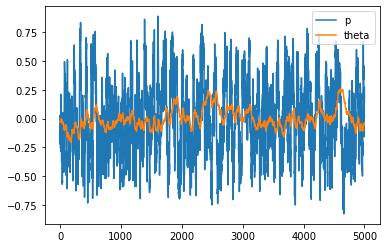

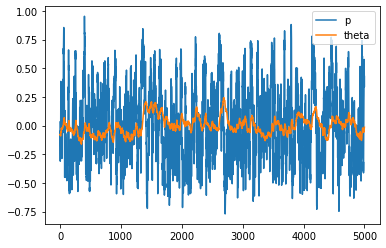

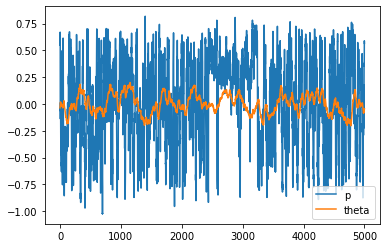

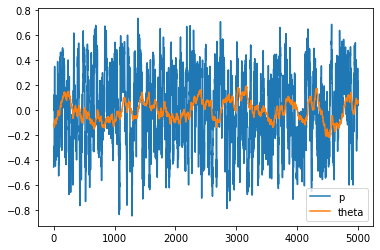

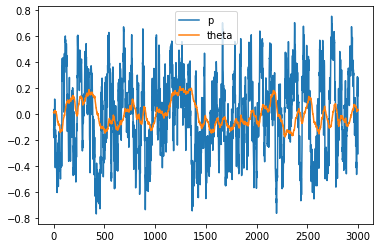

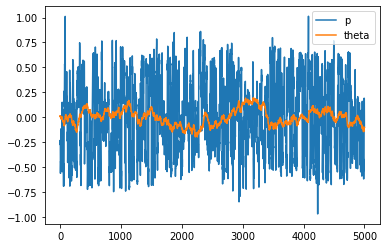

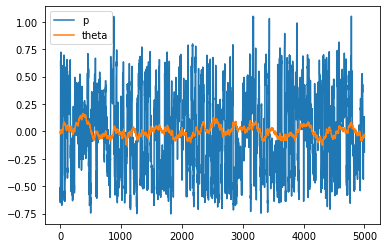

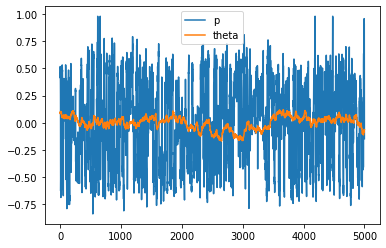

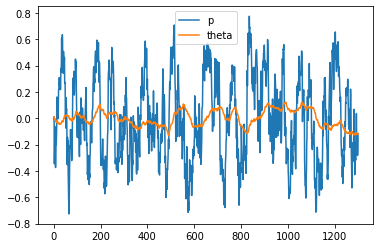

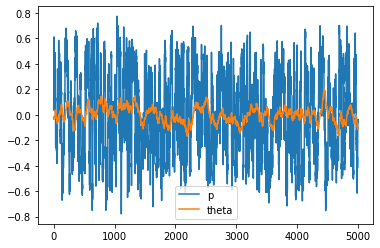

In [8]:
f1 = lambda x: (x[:, 1] - np.mean(x[:, 1]))/180*np.pi
f2 = lambda x: np.mean(x[:, 1:4], axis=1) - np.mean(x[:, 1:4])
f3 = lambda x: x[:, 2] - np.mean(x[:, 2])

data = [np.stack([f1(theta), f3(p)]) for (theta, p) in zip(theta_trajs, pol_trajs)]

for d in data: 
    plt.plot(d[1], label='p')
    plt.plot(d[0], label='theta')
    plt.legend()
    plt.show()

In [9]:
guess = [3, 0.1, 0.1, 1, 1, 1]
bounds = [[1e-10, None], [1e-10, None], [1e-10, None], [1e-10, None], [1e-10, None], [1e-10, None]]
inf = inference()
MAP, y = inf.inf(guess, data, dt, bounds=bounds)
print(MAP, y)
print(MAP[1]+MAP[2]*MAP[3])

/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


[0.089 2.537 0.176 3.574 0.025 0.787] -281808.95183796133
3.1646187634903513


In [10]:
J, B = convert_params(MAP)
print(J)
print(B) 
print(np.linalg.eigvals(J))

[[-0.089  0.176]
 [-0.317 -2.537]]
[[0.001 0.002]
 [0.002 0.628]]
[-0.112 -2.514]


In [11]:
inf2 = exact_inference() 
J2, B2 = inf2.inf(data, dt) 
print(J2)
print(B2)
print(np.linalg.eigvals(J2))

[[-0.088  0.176]
 [-3.97  -2.496]]
[[0.001 0.002]
 [0.002 0.625]]
[-0.426 -2.158]


In [114]:
print(inf2._minuslogP(J, B, data, dt))
print(inf2._minuslogP(J2, B2, data, dt))

-281808.95183796133
-281895.1209629668


In [14]:
n_frames = 5000
m = simple_model(MAP)
m.J = J2 
m.B = B2 
n_repeats = 5
sims = m.evolve(n_frames*dt, 5e-3, n_frames, n_repeats)

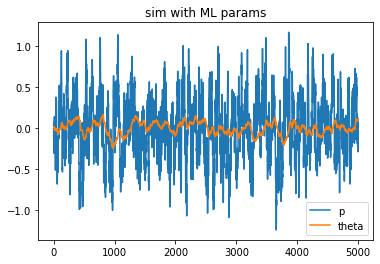

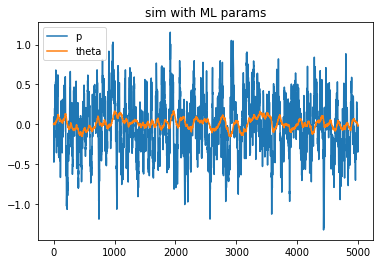

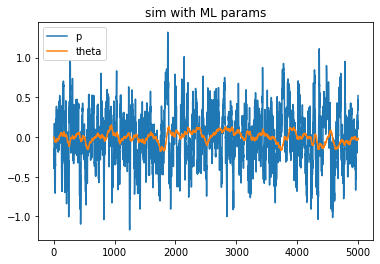

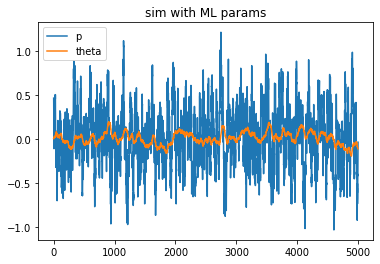

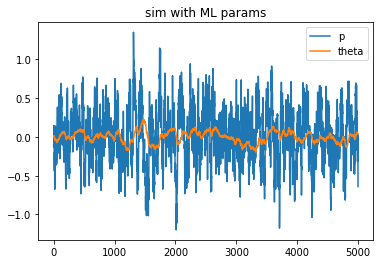

In [16]:
for s in sims: 
    plt.plot(s[1], label='p')
    plt.plot(s[0], label='theta')
    plt.legend()
    plt.title('sim with ML params')
    plt.show() 

### Comparison of different minimisation scheme offered in scipy.minimize class

- Nelder-Mead: -265884.49654086796
- L-BFGS-B: -132018.6884527431
- TNC: -295957.65804476856
- SLSQP: -142196.31471301115
- Powell: -142196.89910920226
- trust: -313247.11678473436 

In [110]:
inf.inf(guess, sims, dt, bounds=bounds)

(array([1.740e-05, 2.306e-05, 2.352e+00, 3.467e-02, 1.165e+00, 5.815e-01]),
 -80350.41315577902)

(16983.18752776544+6294.442171224023j)


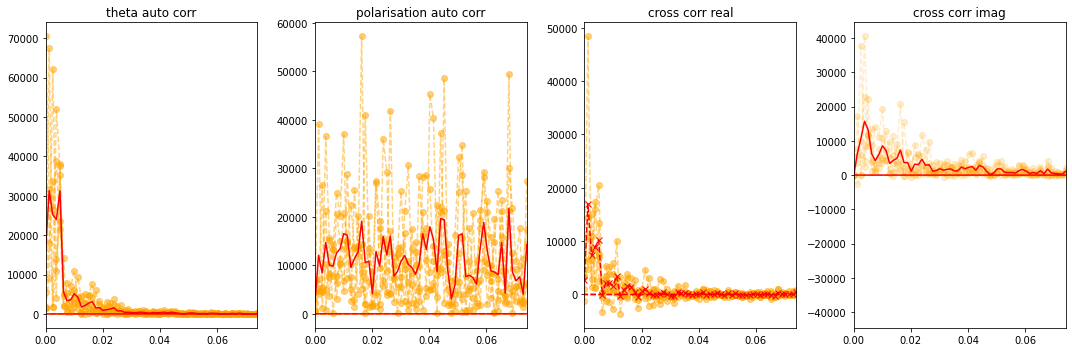

In [117]:
fig, axs = plt.subplots(1, 4, sharex=True, figsize=(15, 5))
L = n_frames
sims = np.array(sims)
thetas = sims[:, 0, :]
ps = sims[:, 1, :]

omegas = np.fft.fftfreq(L)*2*np.pi

for (theta, p) in sims:
    theta_omega = np.fft.fft(theta)
    p_omega = np.fft.fft(p)
    theta_corr = np.abs(theta_omega)**2
    p_corr = np.abs(p_omega)**2
    cross_corr = np.conj(theta_omega)*p_omega
    
    axs[0].plot(omegas, theta_corr, 'o--', alpha=0.5, color='orange')
    axs[1].plot(omegas, p_corr, 'o--', alpha=0.5, color='orange')
    axs[2].plot(omegas, cross_corr.real, 'o--', alpha=0.5, color='orange')
    axs[3].plot(omegas, cross_corr.imag, 'o--', alpha=0.2, color='orange')


theta_corr = np.mean(np.abs(np.fft.fft(thetas))**2, axis=0)
axs[0].plot(omegas, theta_corr, color='red')
axs[0].set_title('theta auto corr')


p_corr = np.mean(np.abs(np.fft.fft(ps))**2, axis=0)
axs[1].plot(omegas, p_corr, color='red')
axs[1].set_title('polarisation auto corr')

cross_corr = np.mean(np.conjugate(np.fft.fft(thetas))*np.fft.fft(ps), axis=0)
axs[2].plot(omegas, cross_corr.real, 'x--', color='red')

axs[2].set_title('cross corr real')
axs[3].plot(omegas, cross_corr.imag, color='red')
axs[3].set_title('cross corr imag')

print(cross_corr[1])


axs[0].set_xlim([0, max(omegas[:60])])
plt.tight_layout()
plt.show()  